Downloaded dataset here: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T 

In [2]:
import sys
import os
import shutil
import io
import torchinfo
import torch
import torch.nn as nn
import csv
import torch.optim as optim
from PIL import Image
import numpy as np
import pandas as pd 
from torchvision import transforms
from torchvision.utils import save_image
import albumentations as A
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import matplotlib.pyplot as plt
import seaborn as sns

# Local
from checkpoint_config import  checkpoint_dir_name, load_checkpoint
from training_and_val import initialize_model, train_and_validate_model, validate_model
from loss_plotter import loss_plotter
from accuracy_plotter import accuracy_plotter 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# map diagnosis dx to names
diagnosis_map = {
    'nv': 'Melanocytic\nNevi',                                   # Common benign mole, usually not concerning, but monitor for changes.
    'mel': 'Melanoma',                                          # Malignant and dangerous, patients with high probability should be checked by a dermatologist urgently.
    'bkl': 'Benign\nKeratosis-like\nLesions',                     # Generally benign, but if rapidly changing or symptomatic, should be checked.
    'bcc': 'Basal Cell\nCarcinoma',                              # Most common skin cancer, rarely metastasizes but should be checked and treated.
    'akiec': 'Actinic Keratoses /\nIntraepithelial\nCarcinoma', # Precancerous or early cancer, should be checked and possibly treated.
    'vasc': 'Vascular\nLesions',                                 # Usually benign, but if rapidly growing or symptomatic, should be checked.
    'df': 'Dermatofibroma'                                      # Benign, but if changing or symptomatic, should be checked.
}

# Helper function to parse accuracy logs
def get_best_epoch_and_accuracy(acc_log_file_path, loss_log_file_path = None):
    best_accuracy = -1
    best_epoch = -1
    best_acc_loss = None
    with open(acc_log_file_path, 'r') as f:
        for line in f:
            if "Validation Accuracy" in line:
                parts = line.strip().split()
                epoch = int(parts[1][:-1])
                val_acc = float(parts[-1])
                if val_acc > best_accuracy:
                    best_accuracy = val_acc
                    best_epoch = epoch
    if loss_log_file_path is not None:
        with open(loss_log_file_path, 'r') as f:
            line = f.readlines()[best_epoch-1]
            parts = line.strip().split()
            best_acc_loss = float(parts[-1])
    return best_epoch, best_accuracy, best_acc_loss

# Helper function to parse loss logs
def get_best_epoch_and_loss(loss_log_file_path, acc_log_file_path=None):
    best_loss = float('inf')
    best_epoch = -1
    best_loss_acc = None
    with open(loss_log_file_path, 'r') as f:
        for line in f:
            if "Validation Loss" in line:
                parts = line.strip().split()
                epoch = int(parts[1][:-1])
                val_loss = float(parts[-1])
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_epoch = epoch
    if acc_log_file_path is not None:
        with open(acc_log_file_path, 'r') as f:
            line = f.readlines()[best_epoch-1]
            parts = line.strip().split()
            best_loss_acc = float(parts[-1])
    return best_epoch, best_loss, best_loss_acc

In [3]:
dataset_path = r"C:\Users\mrlnp\OneDrive - National and Kapodistrian University of Athens\Υπολογιστής\KANs\configs\SKINCANCER\SkinCancerDataset"
csv_path = os.path.join(dataset_path, "HAM10000_metadata.csv")
image_dir = os.path.join(dataset_path, "HAM10000_images")
image_test_dir = image_dir
df = pd.read_csv(csv_path)

unique_diagnoses = df['dx'].unique()
num_classes = len(unique_diagnoses)

nv_df = df[df['dx'] == 'nv'].reset_index()
df = df[~(df['dx'] == 'nv')].reset_index()

# Root Directory to save the training checkpoints
root_dir = "Training Checkpoints Poco"
os.makedirs(root_dir, exist_ok=True)


Hyperparameters:

In [4]:

# Input Dimensions for the model:
x_dim, y_dim = 64,64
channel_size = 3
batch_size = 64
seed = 45482

torch.manual_seed(seed=seed)
np.random.seed(seed)

# Hyperparameter sweep configs
grid_sizes = [[4,]]
learning_rates = [3.0e-05]
hidden_layer_configs = [[1024,]]
epochs = 10
criterion_type = 'BCELoss'
optim_type = 'Adam'
sched_type = 'ReduceOnPlateau'

grid_min_list = [-2]
grid_max_list = [0.25]
inv_denominator_list = [1.5]

probability = 0.25
pretrained = True

In [5]:
# # diagnosis distribution
# plt.figure(figsize=(10, 3))
# sns.countplot(
#     data=df, 
#     x=df['dx'].map(lambda x: '\n'.join(diagnosis_map[x].split())), 
#     order=['\n'.join(diagnosis_map[dx].split()) for dx in df['dx'].value_counts().index]
# )
# plt.title('Diagnosis Distribution')
# plt.xlabel('Diagnosis')
# plt.ylabel('Count')
# plt.xticks(rotation=0)
# plt.grid(True, alpha=0.5)
# plt.show()

In [6]:
# Root Directory to save the training checkpoints
if pretrained:
    pretrained_root_dir = os.path.join(root_dir, "Pretrained")
    os.makedirs(pretrained_root_dir, exist_ok=True)

In [7]:
class SkinCancerDataset(torch.utils.data.Dataset):
    def __init__(self, root, csv_path, output_classes, transform=None):

        self.root = root
        self.transform = transform
        if isinstance(csv_path, str):
            df = pd.read_csv(csv_path)
        else:
            df = csv_path
        df = df.reindex()
        self.image_files = [os.path.splitext(f)[0] for f in os.listdir(root) if f.endswith('.jpg')]

        assert np.sum(df['image_id'].isin(self.image_files)) == len(df)
        self.image_files = df['image_id'].values.tolist()
        # Map class names to integer indices
        classes = df['dx'].unique()
        self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
        
        self.labels = [self.class_to_idx[cls] for cls in df['dx'].values]
        self.output_classes = output_classes

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img_path = os.path.join(self.root, f'{self.image_files[index]}.jpg')
        image = np.asarray(Image.open(img_path).convert("RGB"))
        label = self.labels[index]
        if self.transform:
            image = self.transform(image = image)
        if isinstance(image, dict):
            image = image['image']
        return image.to(torch.float32), label


# Define transforms
basic_transform = A.Compose([
    A.Resize(y_dim,x_dim),
    *([A.ToGray(channel_size,p=1),] if  channel_size == 1 else []),
    A.Normalize(),
    A.ToTensorV2(),
])

# Define the augmentation pipeline
augmented_transform = A.Compose([
    A.Resize(y_dim,x_dim),
    A.RandomResizedCrop(size=(x_dim,y_dim), scale=(0.08, 1.0), p=probability),
    A.HorizontalFlip(p=probability),
    A.VerticalFlip(p=probability),
    A.RGBShift(p=probability),
    A.RandomSunFlare(p=probability),
    A.RandomBrightnessContrast(p=probability),
    A.HueSaturationValue(p=probability),
    A.ColorJitter(p=probability),
    A.RandomRotate90(p=probability),
    A.Perspective(p=probability),
    A.MotionBlur(p=probability),
    A.ChannelShuffle(p=probability),
    A.ChannelDropout(p=probability),
    *([A.ToGray(channel_size,p=1),] if  channel_size == 1 else []),
    A.Normalize(),
    A.ToTensorV2(),
])

In [8]:
splits = [0.75, 0.09, 0.16]
full_dataset = SkinCancerDataset(root=image_dir, csv_path=df, output_classes=num_classes,transform=None)
train_dataset, val_dataset, test_dataset = random_split(full_dataset, splits)

if pretrained:
    df = pd.concat([df, nv_df]).reset_index()
    full_dataset = SkinCancerDataset(root=image_dir, csv_path=df, output_classes=num_classes,transform=None)
    
    train_dataset.dataset = full_dataset
    val_dataset.dataset = full_dataset
    test_dataset.dataset = full_dataset
    
    nv_ind = df[df['dx'] == 'nv'].index.to_list()
    tr_nv_ind, val_nv_ind, test_nv_ind = random_split(nv_ind, splits)

    train_dataset.indices += tr_nv_ind.indices
    val_dataset.indices += val_nv_ind.indices
    test_dataset.indices += test_nv_ind.indices
    

# Define the transforms for all splits
train_dataset.dataset.transform = augmented_transform
val_dataset.dataset.transform = basic_transform
test_dataset.dataset.transform = basic_transform

In [9]:
splits = {
    'Train': train_dataset.indices,
    'Validation': val_dataset.indices,
    'Test': test_dataset.indices
}
diagnosis_order = df['dx'].value_counts().index.tolist()
diagnosis_names = diagnosis_map.values()

In [10]:
# Calculate and display counts per class in the test set
test_counts = df.loc[test_dataset.indices, 'dx'].value_counts().reindex(diagnosis_order, fill_value=0)
for dx, count in test_counts.items():
    print(f"{dx}: {count}")

nv: 538
mel: 371
bkl: 349
bcc: 172
akiec: 97
vasc: 36
df: 38


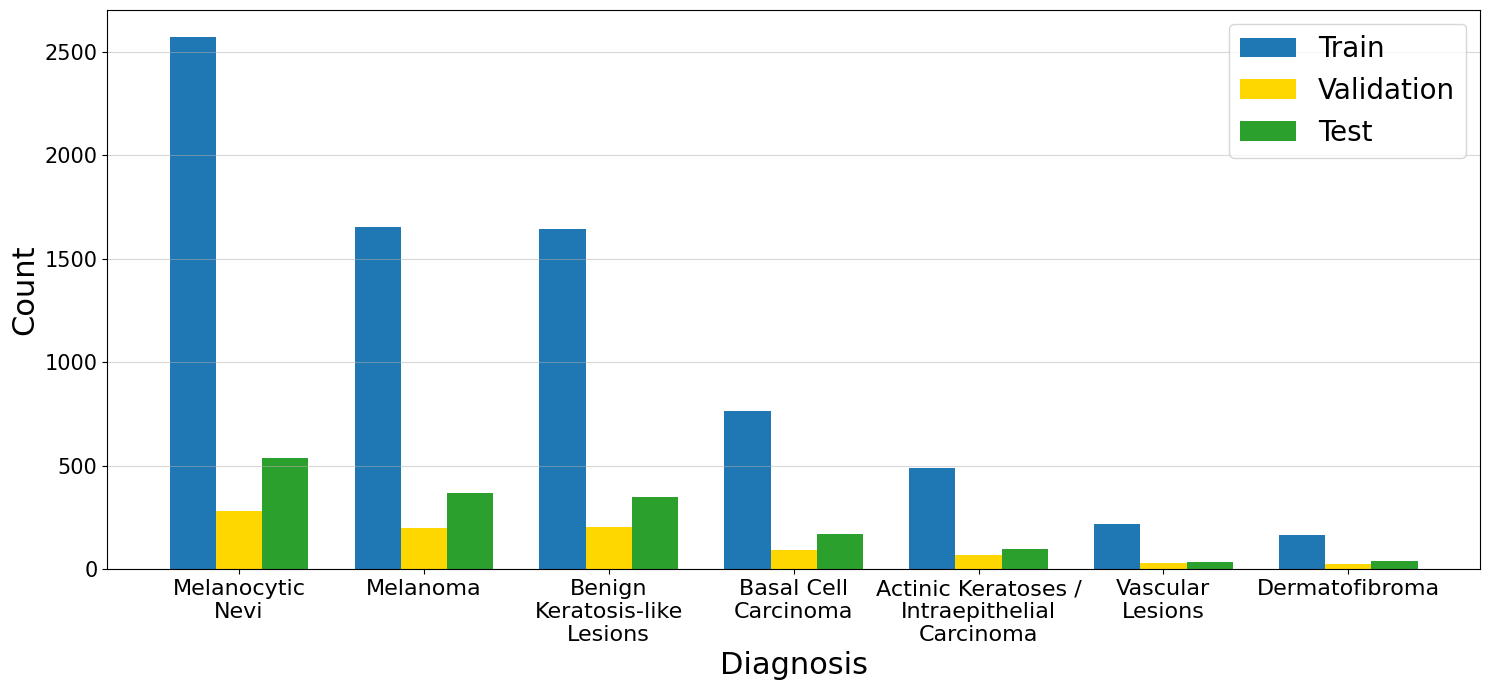

In [12]:
# Plot class distributions for train, val, and test subsets with custom colors

plt.figure(figsize=(15, 7))
bar_width = 0.25
x = np.arange(len(diagnosis_names))

colors = {'Train': '#1f77b4', 'Validation':'gold', 'Test': '#2ca02c'}

for i, (split, indices) in enumerate(splits.items()):
    counts = df.loc[indices, 'dx'].value_counts().reindex(diagnosis_order, fill_value=0)
    plt.bar(x + i * bar_width, counts.values, width=bar_width, label=split, color=colors[split])

plt.xticks(x + bar_width, diagnosis_names, fontsize=16)
plt.yticks(fontsize=15)  
plt.xlabel('Diagnosis', fontsize=22)
plt.ylabel('Count', fontsize=22)  
plt.legend(fontsize=20)
plt.grid(True, axis='y', alpha=0.5)
plt.tight_layout()
plt.show()


In [9]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 7512
Validation dataset size: 902
Test dataset size: 1601


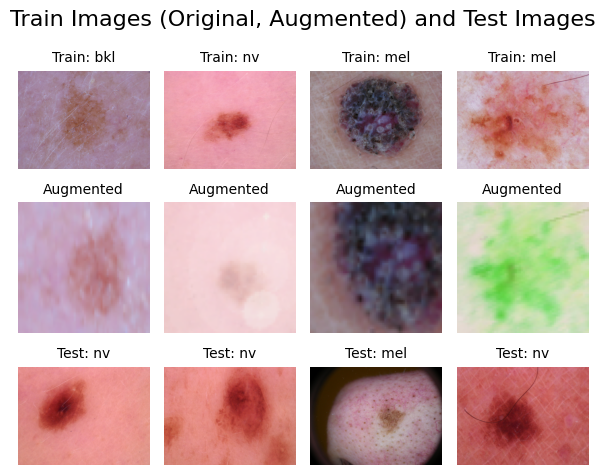

In [10]:
# Show 4 random train images: original, augmented, and 4 test images below
n_cols = 4
n_rows = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6, 5))

np.random.seed(seed)

train_indices = np.random.choice(train_dataset.indices, size=n_cols, replace=False)
test_indices = np.random.choice(test_dataset.indices, size=n_cols, replace=False)

# Row 0: original train images
for i, idx in enumerate(train_indices):
    img_id, dx = df.loc[idx, ['image_id', 'dx']]
    img = np.asarray(Image.open(os.path.join(image_dir, f'{img_id}.jpg')).convert('RGB'))
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Train: {dx}", fontsize=10)
    axes[0, i].axis('off')

# Row 1: augmented train images
for i, idx in enumerate(train_indices):
    img_id, dx = df.loc[idx, ['image_id', 'dx']]
    img = np.asarray(Image.open(os.path.join(image_dir, f'{img_id}.jpg')).convert('RGB'))
    img_aug = np.moveaxis(np.asarray(augmented_transform(image=img)['image']), 0, -1)
    img_aug = img_aug * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_aug = np.clip(img_aug * 255, 0, 255).astype(np.uint8)
    axes[1, i].imshow(img_aug)
    axes[1, i].set_title("Augmented", fontsize=10)
    axes[1, i].axis('off')

# Row 2: test images
for i, idx in enumerate(test_indices):
    img_id, dx = df.loc[idx, ['image_id', 'dx']]
    img = np.asarray(Image.open(os.path.join(image_test_dir, f'{img_id}.jpg')).convert('RGB'))
    axes[2, i].imshow(img)
    axes[2, i].set_title(f"Test: {dx}", fontsize=10)
    axes[2, i].axis('off')

fig.suptitle("Train Images (Original, Augmented) and Test Images", fontsize=16)
plt.tight_layout()
plt.show()


In [11]:
# WeightedRandomSampler is used to address class imbalance by sampling training examples with probability
# proportional to the inverse of their class frequency. This ensures that each mini-batch is more balanced,
# giving minority classes a higher chance to be sampled and preventing the model from being biased toward majority classes.
classes = full_dataset.class_to_idx.keys()

# Calculate class weights using the training set 
train_indices = train_dataset.indices # Get indices of the training samples
train_labels = df.loc[train_indices, 'dx']

class_sample_counts = train_labels.value_counts().reindex(classes, fill_value=0).values
class_weights = 1.0 / torch.tensor(class_sample_counts, dtype=torch.float)
train_labels = train_labels.tolist()

dataset_len = int(len(classes) / np.sqrt(np.mean((1 / class_sample_counts) ** 2)))

In [12]:
for cls, count, weight in zip(classes, class_sample_counts, class_weights):
    print(f"Class: {cls:6} | Count: {count:4d} | Weight: {weight:.4f}")

Class: bkl    | Count: 1645 | Weight: 0.0006
Class: df     | Count:  167 | Weight: 0.0060
Class: mel    | Count: 1655 | Weight: 0.0006
Class: vasc   | Count:  217 | Weight: 0.0046
Class: bcc    | Count:  765 | Weight: 0.0013
Class: akiec  | Count:  489 | Weight: 0.0020
Class: nv     | Count: 2574 | Weight: 0.0004


In [13]:
# Map class names to indices
label_to_idx = full_dataset.class_to_idx
train_label_indices = [label_to_idx[label] for label in train_labels]

# num_workers = os.cpu_count()
num_workers = 0

torch.manual_seed(seed=seed)
sample_weights = [class_weights[label_idx].item() for label_idx in train_label_indices]
sampler = WeightedRandomSampler(sample_weights, num_samples=dataset_len, replacement=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [14]:
# Initialize the model with current hyperparameters
dimension_list = [x_dim * y_dim * channel_size] + hidden_layer_configs[0] + [num_classes]
model, _ = initialize_model(
    root_dir=root_dir,
    dimension=dimension_list,
    grid_size=grid_sizes[0],
    lr=learning_rates[0],
    sched=sched_type,
    optim=optim_type,
    criterion=criterion_type,
    grid_min=grid_min_list[0],
    grid_max=grid_max_list[0],
    inv_denominator=inv_denominator_list[0],
    x_dim=x_dim,
    y_dim=y_dim,
    channel_size=channel_size,
    seed=seed
)
model.to(device)
model.eval()

# Get one sample from the train_loader
sample, label = next(iter(train_loader))
sample = sample.to(device)
with torch.no_grad():
    output = model(sample[0].unsqueeze(0))
print("Model output shape:", output.shape)
print("Output:", output)

input shape: torch.Size([1, 12288])
grid shape: torch.Size([4])
diff shape: torch.Size([1, 12288, 4])
diff_mul shape: torch.Size([1, 12288, 4])
tanh_diff shape: torch.Size([1, 12288, 4])
tanh_diff_derivative shape: torch.Size([1, 12288, 4])
input shape: torch.Size([1, 1024])
grid shape: torch.Size([4])
diff shape: torch.Size([1, 1024, 4])
diff_mul shape: torch.Size([1, 1024, 4])
tanh_diff shape: torch.Size([1, 1024, 4])
tanh_diff_derivative shape: torch.Size([1, 1024, 4])
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
input shape: torch.Size([1, 12288])
grid shape: torch.Size([4])
diff shape: torch.Size([1, 12288, 4])
diff_mul shape: torch.Size([1, 12288, 4])
tanh_diff shape: torch.Size([1, 12288, 4])
tanh_diff_derivative shape: torch.Size([1, 12288, 4])
input shape: torch.Size([1, 1024])
grid shape: torch.Size([4])
diff shape: torch.Size([1, 1024, 4])
diff_mul shape: torch.Size([1,

In [50]:
if pretrained:
    results_csv = os.path.join(pretrained_root_dir, f"hyperparam_results_{seed}.csv")
else :
    results_csv = os.path.join(root_dir, f"hyperparam_results_{seed}.csv")

# Initialize CSV log file only if it does not exist
if not os.path.exists(results_csv):
    with open(results_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            "grid_size", "learning_rate", "hidden_layers", 
            "best_epoch_loss", "best_loss", "best_loss_accuracy", 
            "best_epoch_acc", "best_acc_loss", "best_accuracy", 
            "test_epoch", "test_loss", "test_accuracy", 
            "checkpoint_dir", "grid_min", "grid_max", "inv_denominator", "x_dim", "y_dim",
            "channel_size", "num_classes", "seed", "epochs", "scheduler", "optimizer", "criterion"
        ])

In [51]:
torch.cuda.empty_cache()

In [52]:
# # Begin training
# for grid_min in grid_min_list:
#     for grid_max in grid_max_list:
#         for inv_denominator in inv_denominator_list:
#             for grid_size in grid_sizes:
#                 for lr in learning_rates:
#                     for hidden_layers in hidden_layer_configs:
#                         torch.manual_seed(seed)

#                         dimension_list = [x_dim * y_dim * channel_size] + hidden_layers + [num_classes]
                        
#                         model, _ = initialize_model(
#                             root_dir=root_dir,
#                             dimension=dimension_list,
#                             grid_size=grid_size,
#                             lr=lr,
#                             sched=sched_type,
#                             optim=optim_type,
#                             criterion=criterion_type,
#                             grid_min=grid_min,
#                             grid_max=grid_max,
#                             inv_denominator=inv_denominator,
#                             x_dim=x_dim,
#                             y_dim=y_dim,
#                             channel_size=channel_size,
#                             seed=seed
#                         )
#                         if pretrained:
#                             checkpoint_dir = checkpoint_dir_name(
#                                 criterion_type, optim_type, sched_type, seed, dimension_list, lr,
#                                 grid_size, grid_min, grid_max, inv_denominator, root_dir
#                             )
#                             best_model_path = os.path.join(checkpoint_dir, f"epoch_best", "model_checkpoint.pth")
#                             model, *_ = load_checkpoint(model, checkpoint_path=best_model_path) 
                            
#                             pretrained_lr = lr / 10
#                         else :
#                             pretrained_root_dir = root_dir
#                             pretrained_lr = lr
                            
#                         checkpoint_dir = checkpoint_dir_name(
#                             criterion_type, optim_type, sched_type, seed, dimension_list, pretrained_lr,
#                             grid_size, grid_min, grid_max, inv_denominator, pretrained_root_dir
#                         )
#                         model.to(device)
#                         print(model.parameters())

#                         print(f"\n[INFO] Training | grid_size={grid_size}, lr={pretrained_lr}, layers={hidden_layers}")
#                         print("Checkpoint dir:", checkpoint_dir)

#                         criterion = criterion_type
#                         optimizer = torch.optim.Adam(model.parameters(), lr=pretrained_lr, weight_decay=1e-4)
#                         scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.9,patience=5)

#                         train_and_validate_model(
#                             model=model,
#                             train_loader=train_loader,
#                             val_loader=val_loader,
#                             criterion=criterion,
#                             checkpoint_dir=checkpoint_dir,
#                             optimizer=optimizer,
#                             scheduler=scheduler,
#                             epochs=epochs,
#                             device=device
#                         )

Best Validation Loss:     Epoch: 498 | Loss: 0.0945 | Accuracy: 88.14%
Best Validation Accuracy: Epoch: 463 | Loss: 0.0952 | Accuracy: 88.14%
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Checkpoint loaded from Training Checkpoints Poco\Pretrained\45482\BCELoss\Adam\ReduceOnPlateau\3.0e-05\[12288,1024,7]\[4]\-2.0e+00\2.5e-01\1.5e+00\epoch_best\model_checkpoint.pth. Next epoch is 498.
Model loaded from checkpoint: Training Checkpoints Poco\Pretrained\45482\BCELoss\Adam\ReduceOnPlateau\3.0e-05\[12288,1024,7]\[4]\-2.0e+00\2.5e-01\1.5e+00\epoch_best\model_checkpoint.pth


Validating:   0%|          | 0/26 [00:00<?, ?batch/s]

F1 Score: 0.8672
Recall: 0.8670
Accuracy: 86.70%
Confusion Matrix:
[[272   5  29   3  16  11  13]
 [  2  29   2   0   5   0   0]
 [ 42   2 309   4   7   5   2]
 [  2   0   0  34   0   0   0]
 [ 12   3   5   3 141   7   1]
 [  3   2   3   0   9  79   1]
 [  5   4   3   0   0   2 524]]


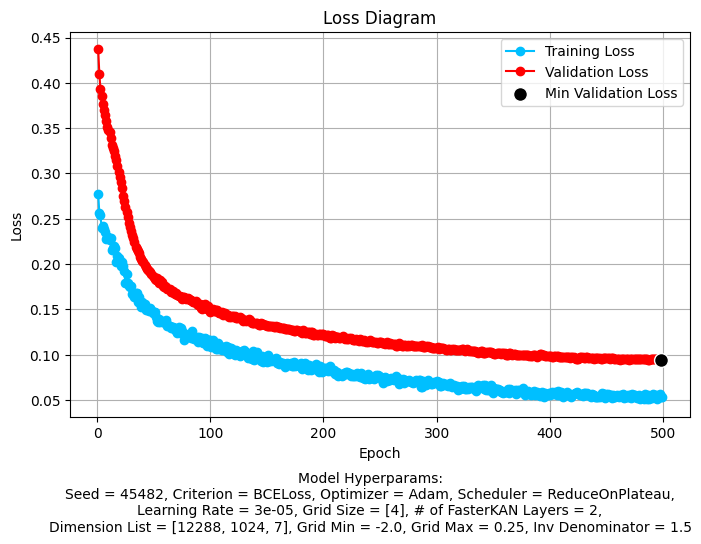

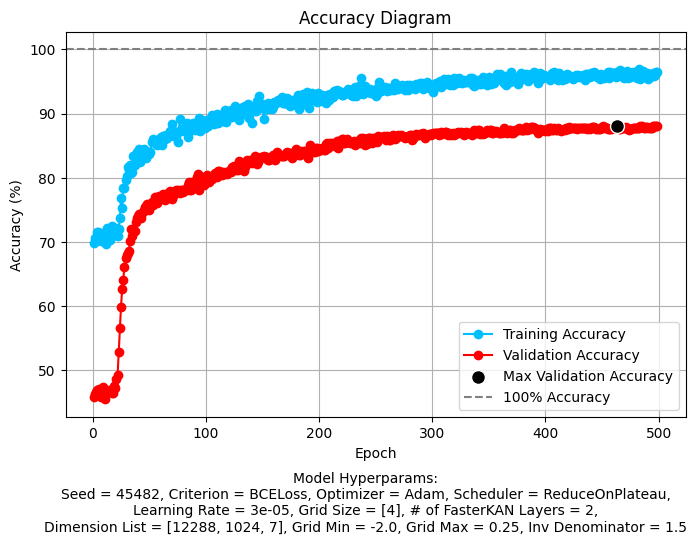

In [53]:
# Begin testing
for grid_min in grid_min_list:
    for grid_max in grid_max_list:
        for inv_denominator in inv_denominator_list:
            for grid_size in grid_sizes:
                for lr in learning_rates:
                    for hidden_layers in hidden_layer_configs:
                        torch.manual_seed(seed)
                        
                        dimension_list = [x_dim * y_dim * channel_size] + hidden_layers + [num_classes]
                        
                        if not pretrained:
                            pretrained_root_dir = root_dir
                            
                        checkpoint_dir = checkpoint_dir_name(
                            criterion_type, optim_type, sched_type, seed, dimension_list, lr,
                            grid_size, grid_min, grid_max, inv_denominator, pretrained_root_dir
                        )
                        
                        acc_log_path = os.path.join(checkpoint_dir, "accuracy_logs.txt")
                        loss_log_path = os.path.join(checkpoint_dir, "loss_logs.txt")
                        best_epoch_loss, best_loss, best_loss_acc = get_best_epoch_and_loss(loss_log_path,acc_log_path)
                        best_epoch_acc, best_accuracy, best_acc_loss = get_best_epoch_and_accuracy(acc_log_path,loss_log_path)
                        print(f"Best Validation Loss:     Epoch: {best_epoch_loss} | Loss: {best_loss:.4f} | Accuracy: {best_loss_acc:.2f}%")
                        print(f"Best Validation Accuracy: Epoch: {best_epoch_acc} | Loss: {best_acc_loss:.4f} | Accuracy: {best_accuracy:.2f}%")

                        model, _ = initialize_model(
                            root_dir=pretrained_root_dir,
                            dimension=dimension_list,
                            grid_size=grid_size,
                            lr=lr,
                            sched=sched_type,
                            optim=optim_type,
                            criterion=criterion_type,
                            grid_min=grid_min,
                            grid_max=grid_max,
                            inv_denominator=inv_denominator,
                            x_dim=x_dim,
                            y_dim=y_dim,
                            channel_size=channel_size,
                            seed=seed
                        )
                        criterion = criterion_type

                        # Load best model
                        best_model_path = os.path.join(checkpoint_dir, f"epoch_best", "model_checkpoint.pth")
                        test_loss, test_accuracy = validate_model(
                            model=model,
                            val_loader=test_loader,
                            criterion=criterion,
                            checkpoint_path=best_model_path,
                            optimizer=optim_type,
                            device=device,
                            metrics_flag=True
                        )

                        # Log to CSV
                        with open(results_csv, mode='a', newline='', encoding='utf-8') as file:
                            writer = csv.writer(file)
                            writer.writerow([
                                grid_size,
                                lr,
                                str(hidden_layers),
                                best_epoch_loss,
                                best_loss,
                                best_loss_acc,
                                best_epoch_acc,
                                best_acc_loss,
                                best_accuracy,
                                'best',
                                test_loss,
                                test_accuracy,
                                checkpoint_dir,
                                grid_min,
                                grid_max,
                                inv_denominator,
                                x_dim,
                                y_dim,
                                channel_size,
                                num_classes,
                                seed,
                                epochs,
                                optim_type,
                                criterion_type
                            ])
                        # Plot training logs
                        loss_plotter(checkpoint_dir)
                        accuracy_plotter(checkpoint_dir)


In [54]:

# for grid_min in grid_min_list:
#     for grid_max in grid_max_list:
#         for inv_denominator in inv_denominator_list:
#             for grid_size in grid_sizes:
#                 for lr in learning_rates:
#                     for hidden_layers in hidden_layer_configs:
            
#                         dimension_list = [x_dim * y_dim * channel_size] + hidden_layers + [num_classes]
                        
#                         if not pretrained:
#                             pretrained_root_dir = root_dir
                            
#                         checkpoint_dir = checkpoint_dir_name(
#                             criterion_type, optim_type, sched_type, seed, dimension_list, lr,
#                             grid_size, grid_min, grid_max, inv_denominator, pretrained_root_dir
#                         )
                        
#                         model, _ = initialize_model(
#                             root_dir=root_dir,
#                             dimension=dimension_list,
#                             grid_size=grid_size,
#                             lr=lr,
#                             sched=sched_type,
#                             optim=optim_type,
#                             criterion=criterion_type,
#                             grid_min=grid_min,
#                             grid_max=grid_max,
#                             inv_denominator=inv_denominator,
#                             x_dim=x_dim,
#                             y_dim=y_dim,
#                             channel_size=channel_size,
#                             seed=seed
#                         )
                        
#                         # Load best model
#                         best_model_path = os.path.join(checkpoint_dir, f"epoch_best", "model_checkpoint.pth")
#                         model, *_ = load_checkpoint(model, checkpoint_path=best_model_path) 
                        
#                         print(model.state_dict())